<a href="https://colab.research.google.com/github/Sometimesemo/Fake-News-Classifier/blob/main/Fake_News_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Environment Setup**

Command lines for installing the required libraries:

In [ ]:
# Data Visualization
!pip install matplotlib
!pip install seaborn

# NLP Tools
!pip install nltk
!pip install spacy

# Installing required NLTK data packages
!python -m nltk.downloader popular

# Installing spaCy's English model
!python -m spacy download en_core_web_sm

# Machine Learning (Part of scikit-learn)
!pip install scikit-learn

# Installing xgboost
!pip install xgboost

# Visualization of specific NLP Tools
!pip install wordcloud


Required Libraries and Imports:

In [2]:
# Basic Data Processing and Mathematics
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing and Regular Expressions
import re

# NLP Tools
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy

# Machine Learning: Data Preparation and Feature Extraction
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Machine Learning: Classification Algorithms
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from xgboost import XGBClassifier

# Machine Learning: Model Evaluation and Optimization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# Visualization of specific NLP Tools
from wordcloud import WordCloud

# Plotting/ Testing
import joblib
from joblib import dump, load
from collections import Counter
from spacy.cli import download


Reading the Dataset and Assigning to the Name "df"

In [4]:
# Import Dataset 'news_articles.csv'
# Change the correct Filepath if needed

df = pd.read_csv('news_articles.csv')


# **2. Dataset Analysis and Data Cleaning**

This section focuses on analyzing and cleaning the dataset. We start by examining the initial state of the dataset, identifying necessary modifications, and making appropriate changes to prepare the data for machine learning modeling.

In [5]:
# Displaying the first few rows of the dataset
df.head(3)


,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0


In [6]:
# Grouping the contents of the 'label' column and displaying the total count
print(f"{df['label'].value_counts()}\n\n")

# Counting all NaN values in the entire CSV
print(f'Number of NaN values in the entire CSV: {df.isna().sum()}\n\n')

# Counting the number of rows in the CSV
print(f'Number of rows in the CSV: {len(df)}\n\n')


Fake    1294
Real     801
Name: label, dtype: int64


Number of NaN values in the entire CSV: author                      0
published                   0
title                       0
text                       46
language                    1
site_url                    1
main_img_url                1
type                        1
label                       1
title_without_stopwords     2
text_without_stopwords     50
hasImage                    1
dtype: int64


Number of rows in the CSV: 2096




#### Overview of Dataset Versions:

**`df`: The Unaltered Dataset**
- This is the original dataset where only the 'Fake'/‘Real’ values in the 'label' column have been changed to 1/0, and 'bs' to 'bullshit' for clarity.

**`df_reduced`: The Manipulated Dataset**
- We have chosen to create a new dataset named `df_reduced`, which will be used for further processing and analysis.


#### Rationale Behind Column Selection:

**Pre-removal of NaN Rows**
- The decision on which columns to retain is made before removing NaN rows. This approach ensures we do not inadvertently discard rows where NaN values are present in columns that will be excluded eventually.

**Focus on 'title' and 'text' Columns**
- We decided to focus on the 'title' and 'text' columns as features for our model. This decision was influenced by existing analyses on Kaggle, which include a broader range of columns. Our goal is to observe how predictions vary when only text data is used.
- The 'type' column was initially unclear to us, prompting a separate, more detailed analysis. Ultimately, we chose 'label' as our target variable, encoding Fake News as 1 and Not Fake News as 0.

**Reason for Removing Pre-processed Stopwords Columns**
- We opted to perform our own stopwords removal for the sake of learning and to ensure uniform formatting between the training texts and texts to be labeled later. This uniformity is crucial for the accuracy and reliability of our model. Unfortunately, we lack specific details on how stopwords were originally removed in the dataset.


**Converting 'Fake' and 'Real' to Numerical Values**
- Machine learning models typically work with numerical data. Converting text labels to numerical values (1 for Fake, 0 for Real) allows the model to process data more efficiently.
- This transformation ensures uniform data formats, simplifying the learning process as many machine learning algorithms, especially classification algorithms, expect numerical input data.
- Numerical encoding enhances computational efficiency since number operations are generally faster than text data operations.
- In this context, encoding 1 as 'Fake' and 0 as 'Real' allows the model to interpret '1' as the class for Fake News and '0' for genuine, verified news, a method often referred to as binary encoding, effective for binary classification problems.


In [7]:
# Replacing 'Fake' and 'Real' in the 'label' column with 1 and 0
df['label'] = df['label'].map({'Fake': 1, 'Real': 0})


**Changing 'bs' to 'bullshit' in 'type' Column**
- The change from 'bs' to 'bullshit' in the 'type' column is more about clarity than necessity. This change does not hold significant analytical value and could be mentioned more aptly in dataset documentation or description.


In [8]:
# Replacing 'bs' with 'bullshit' in the 'type' column
df['type'] = df['type'].replace('bs', 'bullshit', regex=True)


#### Removing Redundant Columns

To streamline our dataset for analysis, we remove several columns that are not relevant to our study. This includes columns like 'author', 'published', etc., which do not contribute to our goal of Fake News classification. By focusing only on the most pertinent data, we aim to enhance the model's accuracy and reduce noise in the dataset.


In [9]:
# Dropping unnecessary columns
df_reduced = df.drop(columns=['author', 'published', 'language', 'site_url', 'main_img_url', 'title_without_stopwords', 'text_without_stopwords', 'hasImage'], errors='ignore')

# Displaying the first row of the reduced dataset
df_reduced.head(1)


,title,text,type,label
0,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,bias,0.0


#### Detailed Analysis of the 'type' Column

We conducted a thorough analysis of the 'type' column to understand its significance and implications. Initially, the purpose and classification criteria of this column were unclear, leading us to investigate it further. Despite its potential as an influential factor, we decided to exclude it from our final model. This decision was driven by the lack of clarity in how 'type' values were assigned and the realization that such information might not be available for new texts in a real-world application. Moreover, we observed that certain 'type' declarations like 'bias', 'state', 'hate' were exclusively associated with Fake News, potentially skewing the learning process by implicitly including the label within the features.


Amount of each type:
bullshit      601
bias          436
conspiracy    430
hate          244
satire        146
state         121
junksci       102
fake           15
Name: type, dtype: int64



Amount of each type in %:
bullshit      28.687351
bias          20.811456
conspiracy    20.525060
hate          11.646778
satire         6.968974
state          5.775656
junksci        4.868735
fake           0.715990
Name: type, dtype: float64





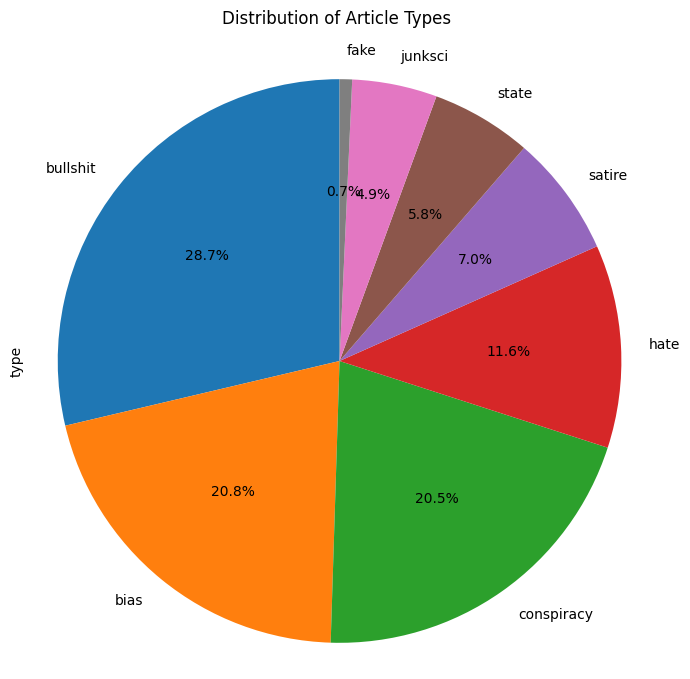

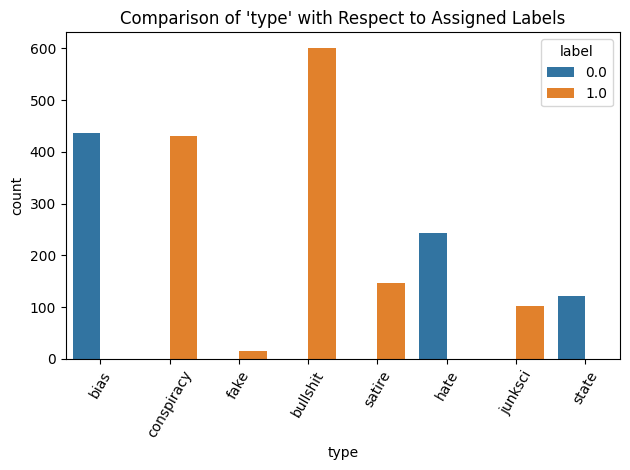

In [10]:
# Grouping contents of the 'type' column and displaying the total count
print("Amount of each type:")
print(df['type'].value_counts())

print("\n\n")

print("Amount of each type in %:")
print(df['type'].value_counts(normalize = True) * 100)

print("\n\n")

# Creating a pie chart to visualize the distribution of article types
df['type'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8, 8), startangle=90)
plt.title('Distribution of Article Types \n')
plt.axis('equal')  # Equal axis for better pie chart representation
plt.show()

# Visual comparison of 'type' with respect to the assigned labels
sns.countplot(x=df_reduced['type'], hue=df_reduced['label'])
plt.title("Comparison of 'type' with Respect to Assigned Labels")
plt.xticks(rotation=60)
plt.tight_layout()


In [11]:
# Dropping the 'type' column
columns_to_drop = ['type']
df_reduced = df_reduced.drop(columns=columns_to_drop, errors='ignore')

# Displaying a sample row to confirm the drop
print("Rows: \n")
df_reduced.sample(1)


Rows: 



,title,text,label
1361,how to heal hemorrhoids fast,at a donald trump rally in north carolina a pr...,1.0


#### Final Data Cleaning: Removing Rows with NaN Values

In the final stage of data cleaning, we remove rows containing NaN values from the remaining relevant columns. The size of our dataset allows us to make this decision without significantly impacting the amount of data available for training. This step is crucial for improving data quality and ensuring reliable model performance.


In [12]:
# Removing rows with NaN values (axis=0 for rows)
df_reduced = df_reduced.dropna(axis=0)

# Displaying the count of NaN values after cleaning
print(f'Number of NaN values in the entire CSV: {df_reduced.isna().sum()}\n\n')

# Displaying the number of rows after cleaning
print(f'Number of rows in the CSV: {len(df_reduced)}\n\n')


Number of NaN values in the entire CSV: title    0
text     0
label    0
dtype: int64


Number of rows in the CSV: 2050




# **3. Preprocessing**
Preprocessing is a critical step in text analysis, especially for NLP (Natural Language Processing) tasks. It involves preparing and cleaning text data to make it suitable for modeling. Key preprocessing steps include removing stopwords, normalizing, and lemmatizing the text.



####Removing Stopwords
Stopwords are commonly used words (such as "the", "is", "in") that are excluded in the processing of text data. They are removed because they typically do not contribute to the understanding of the content and can reduce the model's performance by introducing noise.


In [13]:
sns.set_theme()

# Load stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

nlp = spacy.load('en_core_web_sm')

def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

# Remove stopwords and save the cleaned texts
df_reduced['title_cleaned'] = df_reduced['title'].apply(remove_stopwords)
df_reduced['text_cleaned'] = df_reduced['text'].apply(remove_stopwords)

# Check the changes
print(df_reduced[['title_cleaned', 'text_cleaned']])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                          title_cleaned  \
0           muslims busted stole millions govt benefits   
1            attorney general loretta lynch plead fifth   
2     breaking weiner cooperating fbi hillary email ...   
3     pin drop speech father daughter kidnapped kill...   
4     fantastic trumps point plan reform healthcare ...   
...                                                 ...   
2045                  trump vs clinton risk vs disaster   
2046                    gingrich slutshames megyn kelly   
2047                    youtube bans clintons black son   
2048             wikileaks bombshells hillary need know   
2049                                     fascinated sex   

                                           text_cleaned  
0     print pay back money plus interest entire fami...  
1     attorney general loretta lynch plead fifth bar...  
2     red state fox news sunday reported morning ant...  
3     email kayla mueller prisoner tortured isis cha...  
4

**Note on Cleaned Texts**
The cleaned texts are not stored in the original 'title' and 'text' columns. Instead, new columns 'title_cleaned' and 'text_cleaned' are created. This allows us to maintain the original text for reference while using the cleaned text for analysis. Consequently, the original 'title' and 'text' columns will be dropped from the dataset.


In [16]:
print("New columns:")
df_reduced.head(1)

New columns:


,label,title_cleaned,text_cleaned
0,0.0,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...


In [17]:
# Dropping unnecessary columns
df_reduced = df_reduced.drop(columns=['title', 'text','author', 'published', 'language', 'site_url', 'main_img_url', 'title_without_stopwords', 'text_without_stopwords', 'hasImage'], errors='ignore')

print("New df_reduced:")
df_reduced.head(1)


New df_reduced:


,label,title_cleaned,text_cleaned
0,0.0,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...


**Text Normalization**
Text normalization involves converting text to a more consistent and standard form. This is important in NLP to reduce the complexity of the text and to bring uniformity. The process typically includes converting all characters to lowercase, removing special characters and numbers, and reducing multiple spaces to a single space.


In [18]:
# Function for text normalization
def normalize_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zäöüß]', ' ', text)  # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove multiple spaces
    return text

# Apply the normalization function to the desired columns
df_reduced['title_cleaned'] = df_reduced['title_cleaned'].apply(normalize_text)
df_reduced['text_cleaned'] = df_reduced['text_cleaned'].apply(normalize_text)

# Display the first few rows of the DataFrame for verification
print(df_reduced.head())


   label                                      title_cleaned  \
0    0.0        muslims busted stole millions govt benefits   
1    0.0         attorney general loretta lynch plead fifth   
2    0.0  breaking weiner cooperating fbi hillary email ...   
3    0.0  pin drop speech father daughter kidnapped kill...   
4    0.0  fantastic trumps point plan reform healthcare ...   

                                        text_cleaned  
0  print pay back money plus interest entire fami...  
1  attorney general loretta lynch plead fifth bar...  
2  red state fox news sunday reported morning ant...  
3  email kayla mueller prisoner tortured isis cha...  
4  email healthcare reform make america great sin...  


**Lemmatization**
Lemmatization is the process of converting words to their base or root form. This step is crucial in NLP as it helps in reducing the inflectional forms of each word, thereby simplifying the analysis. For instance, "running", "ran", and "runs" would all be converted to their lemma "run". This process aids in standardizing words for better comparison and analysis.


In [19]:
# Function for lemmatizing text
def lemmatize_text(text):
    doc = nlp(text)  # Create a spaCy document
    lemmatized_text = ' '.join([token.lemma_ for token in doc])  # Lemmatize each token
    return lemmatized_text

# Apply the lemmatization function to the desired columns
df_reduced['title_cleaned'] = df_reduced['title_cleaned'].apply(lemmatize_text)
df_reduced['text_cleaned'] = df_reduced['text_cleaned'].apply(lemmatize_text)

# Display the first few rows of the DataFrame for verification
print(df_reduced.head())


   label                                      title_cleaned  \
0    0.0             muslim bust stole million govt benefit   
1    0.0         attorney general loretta lynch plead fifth   
2    0.0  break weiner cooperate fbi hillary email inves...   
3    0.0  pin drop speech father daughter kidnap kill is...   
4    0.0  fantastic trump point plan reform healthcare b...   

                                        text_cleaned  
0  print pay back money plus interest entire fami...  
1  attorney general loretta lynch plead fifth bar...  
2  red state fox news sunday report morning antho...  
3  email kayla mueller prisoner torture isis chan...  
4  email healthcare reform make america great sin...  


**TF-IDF Vectorization**
The final step in preprocessing is TF-IDF (Term Frequency-Inverse Document Frequency) vectorization. This technique transforms the cleaned text into numerical values, representing the importance of each word in the context of the document. TF-IDF is particularly useful in highlighting the most relevant words in each document, making it a powerful tool for tasks like classification.


In [20]:
# TF-IDF vectorization
tfidf_cleaned = TfidfVectorizer(max_features=5000)


# **4. Training Standard Models**

This section is dedicated to training and evaluating several standard machine learning models. We employ popular algorithms like Naive Bayes, Random Forest, XGBoost, and AdaBoost to predict whether news articles are fake or real. The process includes splitting the data, training each model, and evaluating their performance based on accuracy and recall.


In [25]:
# Function to train models and store results
def train_and_evaluate(X, y):
    # Splitting data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Dictionary to store results
    results = {}

    # Naive Bayes Classifier
    nb_classifier = MultinomialNB()
    nb_classifier.fit(X_train, y_train)
    nb_predictions = nb_classifier.predict(X_test)
    results['Naive Bayes'] = {
        'accuracy': accuracy_score(y_test, nb_predictions),
        'report': classification_report(y_test, nb_predictions)
    }

    # Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)
    rf_predictions = rf_classifier.predict(X_test)
    results['Random Forest'] = {
        'accuracy': accuracy_score(y_test, rf_predictions),
        'report': classification_report(y_test, rf_predictions)
    }

    # XGBoost Classifier
    xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb_classifier.fit(X_train, y_train)
    xgb_predictions = xgb_classifier.predict(X_test)
    results['XGBoost'] = {
        'accuracy': accuracy_score(y_test, xgb_predictions),
        'report': classification_report(y_test, xgb_predictions)
    }

    # AdaBoost Classifier
    adab_classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=5, random_state=1)
    adab_classifier.fit(X_train, y_train)
    adab_predictions = adab_classifier.predict(X_test)
    results['AdaBoost'] = {
        'accuracy': accuracy_score(y_test, adab_predictions),
        'report': classification_report(y_test, adab_predictions)
    }

    return results

# Combining title and text into a new column
df_reduced['combined_text'] = df_reduced['title_cleaned'] + " " + df_reduced['text_cleaned']
# Applying TfidfVectorizer to the combined column
X_cleaned = tfidf_cleaned.fit_transform(df_reduced['combined_text']).toarray()
results_cleaned = train_and_evaluate(X_cleaned, df_reduced['label'])
# Combining results into a dictionary
final_results = {'tfidf_cleaned': results_cleaned}

# Print formatted results
def print_formatted_results(results):
    for tfidf_key, models_results in results.items():
        print(f"Results for {tfidf_key}:\n")
        for model_name, model_results in models_results.items():
            print(f"Model: {model_name}")
            print(f"Accuracy: {model_results['accuracy']}")
            print("Classificationreport:")
            print(model_results['report'])
            print("-" * 50)
        print("=" * 100)

print_formatted_results(final_results)

Results for tfidf_cleaned:

Modell: Naive Bayes
Accuracy: 0.7073170731707317
Classificationreport:
              precision    recall  f1-score   support

         0.0       0.77      0.37      0.50       161
         1.0       0.69      0.93      0.79       249

    accuracy                           0.71       410
   macro avg       0.73      0.65      0.64       410
weighted avg       0.72      0.71      0.68       410

--------------------------------------------------
Modell: Random Forest
Accuracy: 0.802439024390244
Classificationreport:
              precision    recall  f1-score   support

         0.0       0.82      0.63      0.72       161
         1.0       0.79      0.91      0.85       249

    accuracy                           0.80       410
   macro avg       0.81      0.77      0.78       410
weighted avg       0.81      0.80      0.80       410

--------------------------------------------------
Modell: XGBoost
Accuracy: 0.7926829268292683
Classificationreport:
      

#### Optimizing Models with Grid Search

To enhance the performance of our models, we use GridSearchCV, a method for tuning hyperparameters. This technique systematically works through multiple combinations of parameter values, cross-validating as it goes to determine the best combination for optimal model performance. We apply this method to each of our models: Naive Bayes, Random Forest, XGBoost, and AdaBoost.


In [26]:
# Define parameter grids for each model
nb_param_grid = {'alpha': [0.01, 0.1, 1]}
rf_param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}
adab_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'base_estimator__max_depth': [1, 2, 3]
}


In [28]:
# Splitting the data for GridSearch
X_cleaned = tfidf_cleaned.fit_transform(df_reduced['combined_text']).toarray()
X_train_gs, X_test_gs, y_train_gs, y_test_gs = train_test_split(X_cleaned, df_reduced['label'], test_size=0.2, random_state=42)


 Conduct GridSearchCV for each model

In [ ]:
# Naive Bayes
nb_grid_search = GridSearchCV(MultinomialNB(), nb_param_grid, cv=5, scoring='recall')
nb_grid_search.fit(X_train_gs, y_train_gs)
best_nb = nb_grid_search.best_estimator_

# Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='recall')
rf_grid_search.fit(X_train_gs, y_train_gs)
best_rf = rf_grid_search.best_estimator_

# XGBoost
xgb_grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_param_grid, cv=5, scoring='recall')
xgb_grid_search.fit(X_train_gs, y_train_gs)
best_xgb = xgb_grid_search.best_estimator_


# Ada Boost
adab_base_estimator = DecisionTreeClassifier(random_state=42)
adab_grid_search = GridSearchCV(AdaBoostClassifier(estimator=adab_base_estimator, random_state=42), adab_param_grid, cv=5, scoring='recall')
adab_grid_search.fit(X_train_gs, y_train_gs)
best_adab = adab_grid_search.best_estimator_


#### Evaluating and Saving the Best Models

After tuning the models using GridSearchCV, we evaluate and compare them based on metrics like accuracy and recall. These metrics provide insights into the models' performance, particularly in correctly identifying fake news (recall). The best parameters from GridSearchCV are used to retrain the models on the training data and then evaluate them on the test data.


In [48]:
# Evaluating and saving the results of the best models
models = {
    'Naive Bayes': best_nb,
    'Random Forest': best_rf,
    'XGBoost': best_xgb,
    'AdaBoost': best_adab
}

for model_name, model in models.items():
    y_pred = model.predict(X_test_gs)
    accuracy = accuracy_score(y_test_gs, y_pred)
    recall = recall_score(y_test_gs, y_pred)
    print(f"Model: {model_name}")
    print(f"Best Parameter: {model.get_params()}")
    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}\n")


Model: Naive Bayes
Best Parameter: {'alpha': 1, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}
Accuracy: 0.7073, Recall: 0.9277

Model: Random Forest
Best Parameter: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Accuracy: 0.7000, Recall: 0.9799

Model: XGBoost
Best Parameter: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interact

Results:

Model: Naive Bayes
Best Parameter:
Accuracy: 0.7073, Recall: 0.9277

Model: Random Forest
Best Parameter:
Accuracy: 0.7000, Recall: 0.9799

Model: XGBoost
Best Parameter:
Accuracy: 0.7000, Recall: 0.9759

Model: AdaBoost
Best Parameter:
Accuracy: 0.6805, Recall: 0.9839


# **5. Plotting Models and Placeholder for Frontend Integration**

This section is dedicated to preparing the models for deployment and creating a testing interface within the notebook as a placeholder for a potential frontend integration. We also implement preprocessing steps on the test data to ensure consistency with the training data.

**Plotting Models**
The term 'plotting' in this context refers to saving the trained models in a format that can be easily loaded and used for predictions, not visual plotting. This is a crucial step for deploying the models in a real-world application.


In [34]:
# Saving the trained models for later use
for model_name, model in models.items():
    name = model_name + '.joblib'
    dump(model, name)


**Manual Input for Testing**
As a temporary measure for testing, we implement a manual input mechanism within the notebook. This allows us to simulate how the models would process and predict new text inputs, mimicking a user interface in a frontend application.


In [35]:
# Manual input for title and text
input_text1 = input("titel: \n")
input_text2 = input("text: \n")


titel: 
Prominent Scientist Claims the Earth is Flat
text: 
A recently published report from a purportedly reputable scientist has sent shockwaves through the scientific community. In a startling turn of events, the report claims that the Earth is flat, contradicting centuries of astronomical research and observation. Experts are skeptical and warn against the spread of misinformation, yet the news is rapidly gaining traction on social media platforms


Example Input for FakeNews:

titel:
*Prominent Scientist Claims the Earth is Flat*

text:
*A recently published report from a purportedly reputable scientist has sent shockwaves through the scientific community. In a startling turn of events, the report claims that the Earth is flat, contradicting centuries of astronomical research and observation. Experts are skeptical and warn against the spread of misinformation, yet the news is rapidly gaining traction on social media platforms*

**Preprocessing Test Data**
It's essential to apply the same preprocessing steps to the test data as were applied to the training data. This includes removing stopwords, normalizing, and lemmatizing the text to ensure that the input data is in a format that the models can process effectively.


In [37]:
# Preprocessing the test data to match the format of the training data
# Make sure spaCy's English model is downloaded
download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')

# Load stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove stopwords
    tokens = word_tokenize(text.lower())
    no_stopwords = [word for word in tokens if word.lower() not in stop_words]

    # Normalize the text
    normalized = re.sub(r'[^a-zäöüß]', ' ', ' '.join(no_stopwords))
    normalized = re.sub(r'\s+', ' ', normalized).strip()

    # Lemmatize the text
    doc = nlp(normalized)
    lemmatized = ' '.join([token.lemma_ for token in doc])
    return lemmatized

# Replace `input_text1` and `input_text2` with your actual text variables
# Apply preprocessing to the input texts
title_input_final = preprocess_text(input_text1)
text_input_final = preprocess_text(input_text2)

print(title_input_final)
print("\n")
print(text_input_final)


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
prominent scientist claim earth flat


recently publish report purportedly reputable scientist send shockwave scientific community startling turn event report claim earth flat contradict century astronomical research observation expert skeptical warn spread misinformation yet news rapidly gain traction social medium platform


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Model Evaluation and Prediction**
We select a model (e.g., AdaBoost) to predict the label of the test data. The prediction is formatted as 'FakeNews' or 'TrueStory' based on the output of the model. This step simulates how the model would be used in an application to classify news articles.


In [44]:
# Saving TfidfVectorizer
joblib.dump(tfidf_cleaned, 'tfidf_vectorizer.joblib')

# Loading the TfidfVectorizer and transforming the input data
tfidf_vectorizer = joblib.load('tfidf_vectorizer.joblib')
combined_input = title_input_final + " " + text_input_final
input_vector = tfidf_vectorizer.transform([combined_input])

# Loading the trained model and making predictions
trained_model = load('AdaBoost.joblib')
prediction = trained_model.predict(input_vector)

# Formatting and displaying the prediction
label_output = "FakeNews!" if prediction == 1 else "TrueStory"
print(label_output)
print("Predicted Label:", prediction)


FakeNews!
Predicted Label: [1.]


In [45]:
# Load the trained models and make predictions
models = ['Naive Bayes', 'Random Forest', 'XGBoost', 'AdaBoost']
model_files = ['Naive Bayes.joblib', 'Random Forest.joblib', 'XGBoost.joblib', 'AdaBoost.joblib']

for model_name, model_file in zip(models, model_files):
    model = load(model_file)
    prediction = model.predict(input_vector)
    print(f"Model: {model_name}, Predicted Label: {prediction}")


Model: Naive Bayes, Predicted Label: [1.]
Model: Random Forest, Predicted Label: [1.]
Model: XGBoost, Predicted Label: [0]
Model: AdaBoost, Predicted Label: [1.]


**Comparing Models and Majority Voting**
In this part, we load all the trained models and use them to predict the label of the test data. We then choose the label that is most frequently predicted by these models. This method, known as majority voting, can help in making a more robust prediction by combining the strengths of multiple models.


In [47]:
# Loading the trained models and making predictions on the test data
models = ['Naive Bayes', 'Random Forest', 'XGBoost', 'AdaBoost']
model_files = ['Naive Bayes.joblib', 'Random Forest.joblib', 'XGBoost.joblib', 'AdaBoost.joblib']

# Collecting predictions from each model
predictions = []
for model_file in model_files:
    model = load(model_file)
    prediction = model.predict(input_vector)[0]  # Get the predicted label
    predictions.append(prediction)

# Determining the most common prediction label
most_common_prediction, count = Counter(predictions).most_common(1)[0]

# Creating the output
# The label is determined as 'Fake News' if the most common prediction is 1, else 'Real News'
label = "Fake News" if most_common_prediction == 1 else "Real News"
output_string = f"The text seems to be {label}, as {count}/4 of the models conclude this."
print(output_string)


The text seems to be Fake News, as 3/4 of the models conclude this.


Example Output:

"*The text seems to be Fake News, as 3/4 of the models conclude this.*"

# **6. Conclusion**

Reflecting on this project, particularly the balance between recall and accuracy, an important consideration emerges. Specifically, in the context of fake news detection, it might be more advantageous to prioritize a higher recall for identifying 'Not Fake News' to ensure the reliability of verifying the truthfulness of content. This approach could be more valuable in providing reliable assertions about whether a text's content is true, even if it means accepting a somewhat lower accuracy (e.g., around 70%). Such a strategy could more effectively counter the spread of false information while maintaining a reasonable level of accuracy.

